# Ensemble Methods

**TODO: Mention continuation of presentation**

**TODO: Link slides**

## Overview

**TODO: Mention using scikit-learn for basic algorithms, hyperparameter tuning them, then using additional frameworks**

## Setup

**TODO: Talk about what is being set up and why**

In [1]:
# TODO: Trim out any of these that aren't used

import sys
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)

# Formatting for seaborn plots
sns.set_context('notebook', font_scale=1.1)
sns.set_style('ticks')

# Displays all dataframe columns
pd.set_option('display.max_columns', None)

%matplotlib inline

2018/07/04 12:23
OS: win32
Python: 3.5.5 | packaged by conda-forge | (default, Apr  6 2018, 16:03:44) [MSC v.1900 64 bit (AMD64)]
NumPy: 1.12.1
Pandas: 0.23.1


Creating an artificial data set with [scikit-learn's make_classification function](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

**Note: The dataset is being kept small to keep within time limits for the talk, but increase the size or swap it out with a real-world dataset to get a better idea of how these algorithms compare under different scenarios**

In [2]:
# Creating an artificial dataset to test algorithms on
data = datasets.make_classification(n_samples=5000,
                                    n_features=10,
                                    n_redundant=5,  # Superfluous features working as noise for the algorithms
                                    flip_y=0.5,  # Introduces additional noise
                                    n_classes=2,
                                    random_state=46)

# Assigning features/labels to variables for ease of use
X = data[0]
y = data[1]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46)

# Putting into a dataframe for viewing
df = pd.DataFrame(X)
df['label'] = y

df.head()

,0,1,2,3,4,5,6,7,8,9,label
0,-1.609606,-0.405804,1.646726,-1.350422,1.028112,0.150770,0.628511,1.589373,-0.470484,-1.568524,1
1,1.422521,1.471273,-2.185650,-0.368431,-1.657457,0.528370,-1.002433,-1.864973,-1.004933,1.438955,1
2,0.908927,-0.049227,0.826947,-0.195883,1.220820,-1.676695,0.720308,0.209854,0.561905,0.758860,1
3,-0.563904,1.131092,-1.771599,-0.056129,-2.047874,2.180386,-1.217147,-0.923479,0.660668,-0.379916,1
4,1.353001,1.391851,-1.782492,0.991630,-1.272597,0.234084,-0.772074,-1.587041,-0.552018,1.347231,0


**TODO: Talk about creating this function for gathering results**

In [3]:
# Data frame for gathering results 
results = pd.DataFrame(columns=['Accuracy', 'LogLoss', 'AUC', 'TrainingTime'])
tuned_results = results.copy()

# Function for training a model and retrieving the results
def train_model_get_results(model, model_name):
    '''
    Trains a model and appends the results to the results dataframe
    
    Input:
        - model: The model with specified hyperparameters to be trained
        - model_name: The name of the model to be used as the index
        - is_tuned: A binary flag for if hyperparameter tuning has been performed
    
    Output: The results dataframe with the model results added
    
    Note: Only works with scikit-learn models
    '''
    
    # Collecting training time for results
    start_time = time.time()
    
    print('Training the model')
    model.fit(X_train, y_train)
    
    end_time = time.time()
    total_training_time = end_time - start_time
    print('Completed')
    
    # Calculating the testing set accuracy with the score method
    accuracy = model.score(X_test, y_test)
    
    # Calcuating the log loss with predicted probabilities
    class_probabilities = model.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    auc = metrics.roc_auc_score(y_test, class_probabilities[:, 1])
    
    # Adding the model results to the results dataframe
    model_results = [accuracy, log_loss, auc, total_training_time]
    results.loc[model_name] = model_results
    
    print('\n', 'Non-tuned results:')
    return results

## Baseline

It's always useful to have a baseline to compare against. I like to use linear/logistic regression due to them being extremely fast to train.

**TODO:** Say something about wanting to be better than random chance or something

In [4]:
# Instantiating the model
logistic_regression = linear_model.LogisticRegression()

# Using our user defined function to train the model and return the results
train_model_get_results(model=logistic_regression, model_name='Logistic Regression')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696,0.604543,0.743498,0.015625


## Bagging

Bagging (bootstrap aggregating) is the technique that aggregates models built with bootstrapping, or sampling with replacement, via a majority vote or by averaging the predictions. The trees are independent of each other and can be built in parallel. 

Bagging models tend to decrease variance.

### Random Forest

The most popular bagging algorithm is the **random forest**. This algorithm works by building a series of decision trees where each tree uses a random selection of variables, and then decision trees vote on the final answer.  

More specifically, for each tree:

- Use a different training sample with replacement (bootstrapping) for the data
- For each node, choose a number of random attributes and find the best split
- Typically is not pruned in order to have a smaller bias

Once these trees are grown, a majority vote among all of the trees will be used to make predictions.

The main ideas here are that the randomness makes a set of diverse models that helps improve accuracy and using random subsets of features at each split helps make it more efficient.

<img src="http://www.globalsoftwaresupport.com/wp-content/uploads/2018/02/ggff5544hh.png">

**Advantages:**
- Robustness against over-fitting
    - Since the model is created through dense randomness, the generalization is typically better, and you can usually increase the accuracy with the number of trees up until a saturation point
- Soft thresholding (boundaries) on the instance space.
- Able to parallelize training multiple trees at once and thus speed up training time

In [5]:
random_forest = ensemble.RandomForestClassifier(n_jobs=-1)  # n_jobs=-1 uses all available cores

train_model_get_results(random_forest, model_name='Random Forest')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015625
Random Forest,0.655333,1.374621,0.693786,0.187489


## Boosting

Boosting methods train a sequence of weak learners (a learner that is barely better than random chance) where each successive model focuses on the parts that the previous model got wrong. The trees have to be built in a sequence and generally cannot be built in parallel without clever tricks.

Boosting models tend to decrease bias.

### Gradient Boosting

**TODO: Explain gradient boosting, how it works, and its advantages**

<img src="https://littleml.files.wordpress.com/2017/03/boosted-trees-process.png">

*Source: [BigML](https://blog.bigml.com/2017/03/14/introduction-to-boosted-trees/)*

**Disadvantages:**
- Typically overfits easier than bagging
- Sensitive to noise & extreme values
- Has to be built sequentially, so cannot parallelize

In [6]:
gradient_boosting = ensemble.GradientBoostingClassifier()

train_model_get_results(gradient_boosting, model_name='Gradient Boosted Trees')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015625
Random Forest,0.655333,1.374621,0.693786,0.187489
Gradient Boosted Trees,0.723333,0.596558,0.733223,0.906195


### Note on interpretability

It's possible to obtain "feature importance" from both bagging and boosting methods. These are not as interpretable as coefficients from linear/logistic regressions, but can still give us an idea of what is happening. 

Note that the multicollinearity assumption applies here - these interpretations will be misleading if the features are heavily correlated with each other.

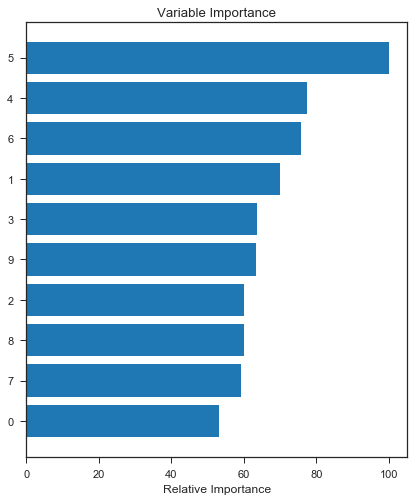

In [7]:
def feature_importance(model):
    '''
    Plots the feature importance for an ensemble model
    '''
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, sorted_idx)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    

feature_importance(random_forest)

## Stacking

**TODO: Explain stacking, how it works, and its advantages/disadvantages**

**TODO: Include a picture for stacking**

**TODO: Check if there's a better way to do stacking w/ scikit-learn**

**TODO: Check if there's a way to avoid repeating fit/predict lines**

In [8]:
def train_stacking_get_results(list_of_models):
    '''
    TODO: Write docstring
    '''
    # The meta learner is the one that takes the outputs from
    # the other models as input before final classification
    meta_learner = linear_model.LogisticRegression()

    # Collecting training time for results
    start_time = time.time()
    print('Training the model')

    # Fitting the first layer models
    for model in list_of_models:
        model.fit(X_train, y_train)

    # Collecting the predictions from the models for training
    model_output = []

    for model in list_of_models:
        class_probabilities = model.predict_proba(X_train)[:, 1]
        model_output.append(class_probabilities)

    # Re-shaping before passing to the meta learner
    X_train_meta = np.array(model_output).transpose()

    # Fitting the meta learner
    meta_learner.fit(X_train_meta, y_train)

    end_time = time.time()
    total_time = end_time - start_time
    print('Completed')

    # Collecting the predictions from the models for testing
    model_output = []

    for model in list_of_models:
        class_probabilities = model.predict_proba(X_test)[:, 1]
        model_output.append(class_probabilities)

    # Re-shaping before passing to the meta learner
    X_test_meta = np.array(model_output).transpose()

    # Collecting the accuracy from the meta learner
    accuracy = meta_learner.score(X_test_meta, y_test)

    # Calcuating the log loss with predicted probabilities
    class_probabilities = meta_learner.predict_proba(X_test_meta)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    auc = metrics.roc_auc_score(y_test, class_probabilities[:, 1])

    model_results = [accuracy, log_loss, auc, total_time]

    results.loc['Stacking'] = model_results

    return results


# Adding extra imports for additional models
from sklearn import neighbors
from sklearn import svm

# Defining the learners for the first layer
model_1 = linear_model.LogisticRegression()
model_2 = ensemble.RandomForestClassifier(n_jobs=-1)
model_3 = neighbors.KNeighborsClassifier(n_jobs=-1)
model_4 = ensemble.GradientBoostingClassifier()
model_5 = svm.SVC(probability=True)

# Putting the models in a list to iterate through in the function
models = [model_1, model_2, model_3, model_4, model_5]

# Running our function to build a stacking model
train_stacking_get_results(models)

Training the model
Completed


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015625
Random Forest,0.655333,1.374621,0.693786,0.187489
Gradient Boosted Trees,0.723333,0.596558,0.733223,0.906195
Stacking,0.650667,1.065496,0.679866,6.265244


# Hyperparameter Tuning

There two main methodologies for hyperparameter tuning: 
1. Manually testing hypotheses on how changing certain hyperparameters will impact the performance of the model
2. Automatically checking a bunch of different combinations of hyperparameters using either a grid search or a randomized search

We will start with the second option by using a randomized search and then see if we have any hypotheses for further improving the model.  **TODO: Take this out if the second doesn't actually happen**

Grid search makes more intuitive sense, but research from [James Bergstra and Yoshua Bengio](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf) have shown that random search tends to converge to good hyperparameters faster than grid search. Here's a graphic from their paper that gives an intuitive example of how random search can potentially cover more ground when there are hyperparameters that aren't as important:

<img src="https://cdn-images-1.medium.com/max/923/1*ZTlQm_WRcrNqL-nLnx6GJA.png">

*Source: [James Bergstra & Yoshua Bengio](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)*

## Hyperparameters & Decision Tree Structure

Because both random forests and gradient boosted trees use decision trees for their underlying structures, their hyperparameters are largely the same. Here's a recap of the decision tree structure and a quick summary of what each of the hyperparameters we'll be tuning are:

<img src="http://3.bp.blogspot.com/-2OYbpGM5AsA/T9_UacNCyxI/AAAAAAAAADI/KWb2PJamTVU/s400/1.png">

*Source: [Murtuza Morbiwala](http://insightfromdata.blogspot.com/2012/06/decision-tree-unembellished.html)*


### Hyperparameters

This is list is not all-inclusive, but has most of the common hyperparameters:

- **Number of Estimators:** The number of decision trees to be trained
    - A higher number typically means better predictions (at the cost of computational power) up until a saturation point where the model begins to overfit
- **Max Depth:** How deep a tree can be
    - This should ideally be low for gradient boosting and large (or none) for random forests
- **Minimum Samples per Split:** The minimum samples considered to split a node
    - A higher number typically results in better performance at the cost of computational efficiency
- **Minimum Samples per Leaf:** The minimum number of samples required to be a leaf node
    - A lower number could potentially result in more noise being captured
- **Max Features:** The number of features to consider when looking for the best split
    - A lower number typically reduces variance/increases bias and improves computational efficiency
- **Max Leaf Nodes:** The maximum number of leaf nodes for the tree
    - A smaller number could help prevent overfitting
- **Learning Rate (gradient boosting only):** The adjustment/step size for each iteration
    - A larger step size can help get better performance in fewer iterations, but will plateau at a lower performance
    - A smaller step size will require more iterations (number of estimators) but will ultimately achieve a better performance

Here is a more visual version of these hyperparameters on a tree: 

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png">

*Source: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)*

### General Strategies

**TODO: Incorporate these into the above**

https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst

For Faster Speed

    Use bagging by setting bagging_fraction and bagging_freq
    Use feature sub-sampling by setting feature_fraction
    Use small max_bin
    Use save_binary to speed up data loading in future learning
    Use parallel learning, refer to Parallel Learning Guide

For Better Accuracy

    Use large max_bin (may be slower)
    Use small learning_rate with large num_iterations
    Use large num_leaves (may cause over-fitting)
    Use bigger training data
    Try dart

Deal with Over-fitting

    Use small max_bin
    Use small num_leaves
    Use min_data_in_leaf and min_sum_hessian_in_leaf
    Use bagging by set bagging_fraction and bagging_freq
    Use feature sub-sampling by set feature_fraction
    Use bigger training data
    Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
    Try max_depth to avoid growing deep tree

In [ ]:
def hyperparameter_tune_get_results(model, parameters, model_name, num_rounds=30):
    '''
    TODO: Fill docstring
    '''
    
    print('Default Parameters:', '\n')
    print(model, '\n')
    
    random_search = RandomizedSearchCV(model,
                                       param_distributions=parameters,
                                       n_iter=num_rounds, n_jobs=-1,
                                       return_train_score=True, random_state=46,
                                       verbose=20)  # Prints status of each completed fit
    
    print('Beginning hyperparameter tuning')
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()
    total_training_time = end_time - start_time
    print('Completed')
    
    # Calculating the testing set accuracy on the best estimator with the score method
    accuracy = random_search.best_estimator_.score(X_test, y_test)
    
    # Calcuating the log loss with predicted probabilities
    class_probabilities = random_search.best_estimator_.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    auc = metrics.roc_auc_score(y_test, class_probabilities[:, 1])
    
    # Adding the model results to the results dataframe
    model_results = [accuracy, log_loss, auc, total_training_time]
    tuned_results.loc[model_name] = model_results
    
    # Plotting the mean training accuracy from the different iterations
    sns.distplot(random_search.cv_results_['mean_test_score'])
    plt.title('Mean test score')
    
    print('Best estimator:', '\n')
    print(random_search.best_estimator_)
    
    print()
    print('Accuracy before tuning:', results.loc[model_name]['Accuracy'])
    print('Accuracy after tuning:', tuned_results.loc[model_name]['Accuracy'])
    
    print('\n', 'Tuned results:')
    return tuned_results

## Baseline

For our logistic regression model, we're just going to tune the regularization parameter. One of the advantages of simpler models like this is that they are easier to tune because we don't have nearly as many hyperparameters to worry about.

**Note: The number of rounds is being kept small in these examples to keep within time limits for the talk, but increase them in a real-world scenario for more effective hyperparameter tuning**

Default Parameters: 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:    3.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    3.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

LogisticRegression(C=7.8383235080575062, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy before tuning: 0.696
Accuracy after tuning: 0.696

 Tuned results:


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696,0.604539,0.7435,3.859142


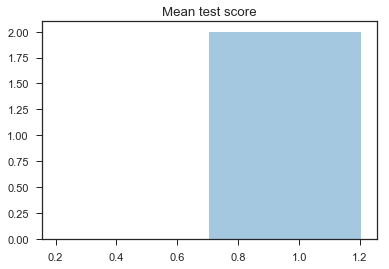

In [9]:
parameters = {'C': scipy.stats.uniform(0, 10)}  # Uniform distribution between 0 and 10

hyperparameter_tune_get_results(model=logistic_regression, parameters=parameters,
                                model_name='Logistic Regression', num_rounds=5)

## Random Forests

**TODO: Explain random forest tuning strategies**

Use [this](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/) as reference

Default Parameters: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   36.0s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   36.3s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   39.8s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   42.0s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:   42.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   43.8s remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=452, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy before tuning: 0.655333333333
Accuracy after tuning: 0.721333333333

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604539,0.743500,3.859142
Random Forest,0.721333,0.600526,0.733113,47.309644


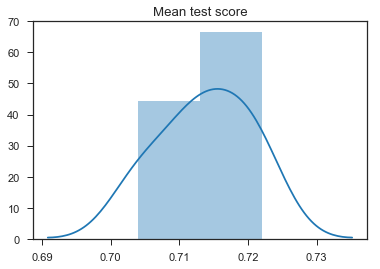

In [10]:
# Creating the dictionary of parameters to use in the search
parameters = {'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 500
              'max_features': ['auto', 'log2', None],  # Number of features to consider at each split
              'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
              'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
             }

hyperparameter_tune_get_results(random_forest, parameters, 'Random Forest', num_rounds=5)

**TODO: Show more directed hyperparameter tuning given current data**

In [11]:
trees_to_try = [10, 50, 100, 300, 500, 1000]

train_accuracy = []
test_accuracy = []

for trees in trees_to_try:
    print('Fitting with {0} trees'.format(trees))
    random_forest = ensemble.RandomForestClassifier(n_estimators=trees, n_jobs=-1)
    random_forest.fit(X_train, y_train)
    
    train_accuracy.append(random_forest.score(X_train, y_train))
    test_accuracy.append(random_forest.score(X_test, y_test))

Fitting with 10 trees
Fitting with 50 trees
Fitting with 100 trees
Fitting with 300 trees
Fitting with 500 trees
Fitting with 1000 trees


In [18]:
# plt.plot(trees_to_try, test_accuracy, label='Test Accuracy')
# plt.plot(trees_to_try, train_accuracy, label='Train Accuracy')
# plt.legend()

pd.DataFrame({'NumTrees': trees_to_try, 'TrainAccuracy': train_accuracy, 'TestAccuracy': test_accuracy})

,NumTrees,TestAccuracy,TrainAccuracy
0,10,0.651333,0.982571
1,50,0.698000,0.998571
2,100,0.694667,1.000000
3,300,0.700000,1.000000
4,500,0.702000,1.000000
5,1000,0.700000,1.000000


## Gradient Boosted Trees

**TODO: Explain GBT tuning strategies & how different components affect the model**

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/Owen-Zhang-Table-of-Suggestions-for-Hyperparameter-Tuning-of-XGBoost.png">

**TODO: Adjust these hyperparameter ranges**

Default Parameters: 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   36.5s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   40.7s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   44.6s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   50.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  1.3min remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=542,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Accuracy before tuning: 0.723333333333
Accuracy after tuning: 0.692666666667

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604539,0.743500,3.859142
Random Forest,0.721333,0.600526,0.733113,47.309644
Gradient Boosted Trees,0.692667,0.737512,0.720375,112.946284


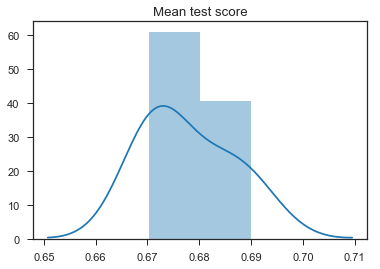

In [19]:
# Creating the dictionary of parameters to use in the search
parameters = {'n_estimators': scipy.stats.randint(low=100, high=1000),  # Uniform distribution between 100 and 1000
              'learning_rate': [0.01, 0.03, 0.1, 0.3],  # How drastic updates arelol
              'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
              'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
             }

hyperparameter_tune_get_results(gradient_boosting, parameters, 'Gradient Boosted Trees', num_rounds=5)

**TODO: Show more directed hyperparameter tuning given current data**

## Stacking

**TODO: Talk about how it's more ambiguous due to being a collection of several models**

# Additional Frameworks

We have been using scikit-learn up until now for our models, but there are more specialized frameworks for gradient boosting in particular. Scikit-learn's gradient boosting algorithm is good, but lacks a few components and options that can be useful.

Specifically, we're going to focus on **XGBoost** and **LightGBM**. We'll go into more specifics for each, but both frameworks have the following advantages & disadvantages:

#### Advantages
- Ability to parallelize training
- Ability to use GPUs
- Additional under-the-hood optimization
- Can specify loss functions
- Additional tuning parameters
- Distributed computing options

#### Disadvantages
- Relatively difficult to install
- Not as unified integration

So generally speaking, XGBoost and LightGBM is able to train better models faster, but can be more difficult to set up and use.

### XGBoost

**TODO: Explain XGBoost, what it is, how it works, and why it's good**

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11194110/leaf.png">

*Source: [LightGBM's GitHub](https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst)*

#### Installation
**TODO: Explain how to install xgboost**

#### Hyperparameter Tuning

### LightGBM

[LightGBM](https://github.com/Microsoft/LightGBM) is a project from [Microsoft Research Asia](https://www.microsoft.com/en-us/research/lab/microsoft-research-asia/) that is focused around training gradient boosted trees in a highly efficient and distributed manner. It's generally comparable to XGBoost, but is not as popular because it is much newer.

One of the fundamental differences between LightGBM and other implementations of gradient boosted trees is that it grows the trees leaf-wise rather than level-wise:

<img src="https://raw.githubusercontent.com/Microsoft/LightGBM/master/docs/_static/images/leaf-wise.png">

*Source: [LightGBM's GitHub](https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst)*

**TODO: Explain why this is important**

Additionally, LightGBM uses a histogram based algorithm to discretize continuous variables into buckets in order to speed up the training process and reduce the memory requirements. XGBoost has included this in a recent version, but it is not enabled by default. **TODO: Validate this**

There are several other optimizations happening under the hood, but those are a few of the main differences from other implementations.

#### Installation

[The documentation on GitHub](https://github.com/Microsoft/LightGBM/tree/master/python-package#installation) has installation instructions for LightGBM. It can be installed from PyPI with `pip install lightgbm`, but requires a few things to work - check out the documentation depending on your OS.

In [20]:
import lightgbm as lgb

lightGBM = lgb.LGBMClassifier(nthread=-1)  # nthread=-1 uses all available cores

# Due to the scikit-learn API option, LightGBM works with our function!
train_model_get_results(lightGBM, 'LightGBM')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015625
Random Forest,0.655333,1.374621,0.693786,0.187489
Gradient Boosted Trees,0.723333,0.596558,0.733223,0.906195
Stacking,0.650667,1.065496,0.679866,6.265244
LightGBM,0.722667,0.600648,0.734010,0.046872


#### Hyperparameter Tuning

In [ ]:
# parameters = {'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 750
#               'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
#               'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
#               'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#               'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
# #               'boostrap': [True, False]
#              }  # If the samples should be bootstrapped or not
             
parameters = {'boosting_type': ['gbdt', 'dart'],
              'n_estimators': scipy.stats.randint(low=50, high=5000),  # Uniform distribution between 10 and 1000
              'learning_rate': [0.01, 0.03, 0.1, 0.3],
#               'num_leaves': 31,
#               'max_depth': 1,
#               'max_bin': 255,
#               'reg_alpha': 0,  # L1 regularization
#               'reg_lambda': 0  # L2 regularization
             }    

hyperparameter_tune_get_results(lightGBM, parameters, 'LightGBM', num_rounds=5)